In [1]:
#%matplotlib inline
%matplotlib notebook
import numpy as np
import matplotlib.pylab as plt
import yt
import h5py
from yt.data_objects.particle_filters import add_particle_filter
from yt.analysis_modules.halo_analysis.halo_catalog import HaloCatalog
from matplotlib.colors import LogNorm
from iminuit import Minuit, describe, Struct


In [2]:
fn = "/data/TMP-outputs/output_00041/info_00041.txt"
fn = "/data/ISAPP_gadget/snapshot_006"
#fn = "/home/arturo/works/Gadget-2.0.7/Gadget2/lcdm_gas/snapshot_005"
# load data
ds = yt.load(fn)
ad = ds.all_data()

yt : [INFO     ] 2017-07-03 10:32:50,705 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2017-07-03 10:32:50,706 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2017-07-03 10:32:50,742 Parameters: current_time              = 4.35581052821e+17 s
yt : [INFO     ] 2017-07-03 10:32:50,743 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-07-03 10:32:50,744 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-07-03 10:32:50,745 Parameters: domain_right_edge         = [ 25000.  25000.  25000.]
yt : [INFO     ] 2017-07-03 10:32:50,747 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-07-03 10:32:50,747 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2017-07-03 10:32:50,748 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2017-07-03 10:32:50,749 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2017-07-03 10:32:50,750 Parameters: hubble_constant           =

In [3]:
f = yt.load("halo_catalogs/catalog/catalog.0.h5")

yt : [INFO     ] 2017-07-03 10:32:50,793 Parameters: current_time              = 4.35581052821e+17
yt : [INFO     ] 2017-07-03 10:32:50,794 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-07-03 10:32:50,796 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-07-03 10:32:50,797 Parameters: domain_right_edge         = [  1.13879450e+26   1.13879450e+26   1.13879450e+26]
yt : [INFO     ] 2017-07-03 10:32:50,798 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-07-03 10:32:50,799 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2017-07-03 10:32:50,800 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2017-07-03 10:32:50,800 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2017-07-03 10:32:50,801 Parameters: hubble_constant           = 0.6774


In [4]:
f.field_list

yt : [INFO     ] 2017-07-03 10:32:50,809 Allocating for 1.032e+04 particles (index particle type 'all')
yt : [INFO     ] 2017-07-03 10:32:50,824 Identified 3.201e+03 octs


[('all', u'particle_identifier'),
 ('all', u'particle_mass'),
 ('all', u'particle_position_x'),
 ('all', u'particle_position_y'),
 ('all', u'particle_position_z'),
 ('all', u'virial_radius'),
 ('halos', u'particle_identifier'),
 ('halos', u'particle_mass'),
 ('halos', u'particle_position_x'),
 ('halos', u'particle_position_y'),
 ('halos', u'particle_position_z'),
 ('halos', u'virial_radius')]

In [5]:
par_x = np.array(ad['particle_position_x'].in_units('pc'),dtype=np.float64)
par_y = np.array(ad['particle_position_y'].in_units('pc'),dtype=np.float64)
par_z = np.array(ad['particle_position_z'].in_units('pc'),dtype=np.float64)
par_mass = np.array(ad['particle_mass'].in_units('Msun'),dtype=np.float64)

yt : [INFO     ] 2017-07-03 10:32:51,080 Allocating for 1.678e+07 particles (index particle type 'all')
yt : [INFO     ] 2017-07-03 10:32:53,384 Identified 1.251e+06 octs


In [6]:
bin_num = 150
xedges = np.linspace(par_x.min(),par_x.max(),bin_num)
yedges = np.linspace(par_y.min(),par_y.max(),bin_num)
lim = 2e6
low_lim, up_lim = 3e7,4e7

par_con = (par_z>low_lim)&(par_z<up_lim)

# Sort out Particles
H, xedges, yedges = np.histogram2d(par_x[par_con], par_y[par_con], bins=(xedges, yedges),weights=par_mass[par_con])
H = H.T

# Sort out halos
halos_data = f.all_data()
halos_x = np.array(halos_data['halos', u'particle_position_x'].in_units('pc'),dtype=np.float64)
halos_y = np.array(halos_data['halos', u'particle_position_y'].in_units('pc'),dtype=np.float64)
halos_z = np.array(halos_data['halos', u'particle_position_z'].in_units('pc'),dtype=np.float64)
halos_r = np.array(halos_data['halos', u'virial_radius'].in_units('pc'),dtype=np.float64)
halos_mass = np.array(halos_data['all', u'particle_mass'].in_units('Msun'),dtype=np.float64)


# Sort out all halos which are more near than 2r than the box boundary
# generically find out box size
a = np.array([par_x, par_y, par_z]).max()
# indices of halos in the box
halos_cond = np.where( ((a-2*halos_r) > halos_x) & ((2*halos_r) < halos_x) & \
                       ((a-2*halos_r) > halos_y) & ((2*halos_r) < halos_y) & \
                       ((a-2*halos_r) > halos_z) & ((2*halos_r) < halos_z))
# sort out
halos_x    = halos_x[halos_cond]
halos_y    = halos_y[halos_cond]
halos_z    = halos_z[halos_cond]
halos_r    = halos_r[halos_cond]
halos_mass = halos_mass[halos_cond]

In [7]:
halos_con = np.where((halos_z>low_lim)&(halos_z<up_lim))
halos_x_f = halos_x[halos_con]
halos_y_f = halos_y[halos_con]
halos_r_f = halos_r[halos_con]

<IPython.core.display.Javascript object>


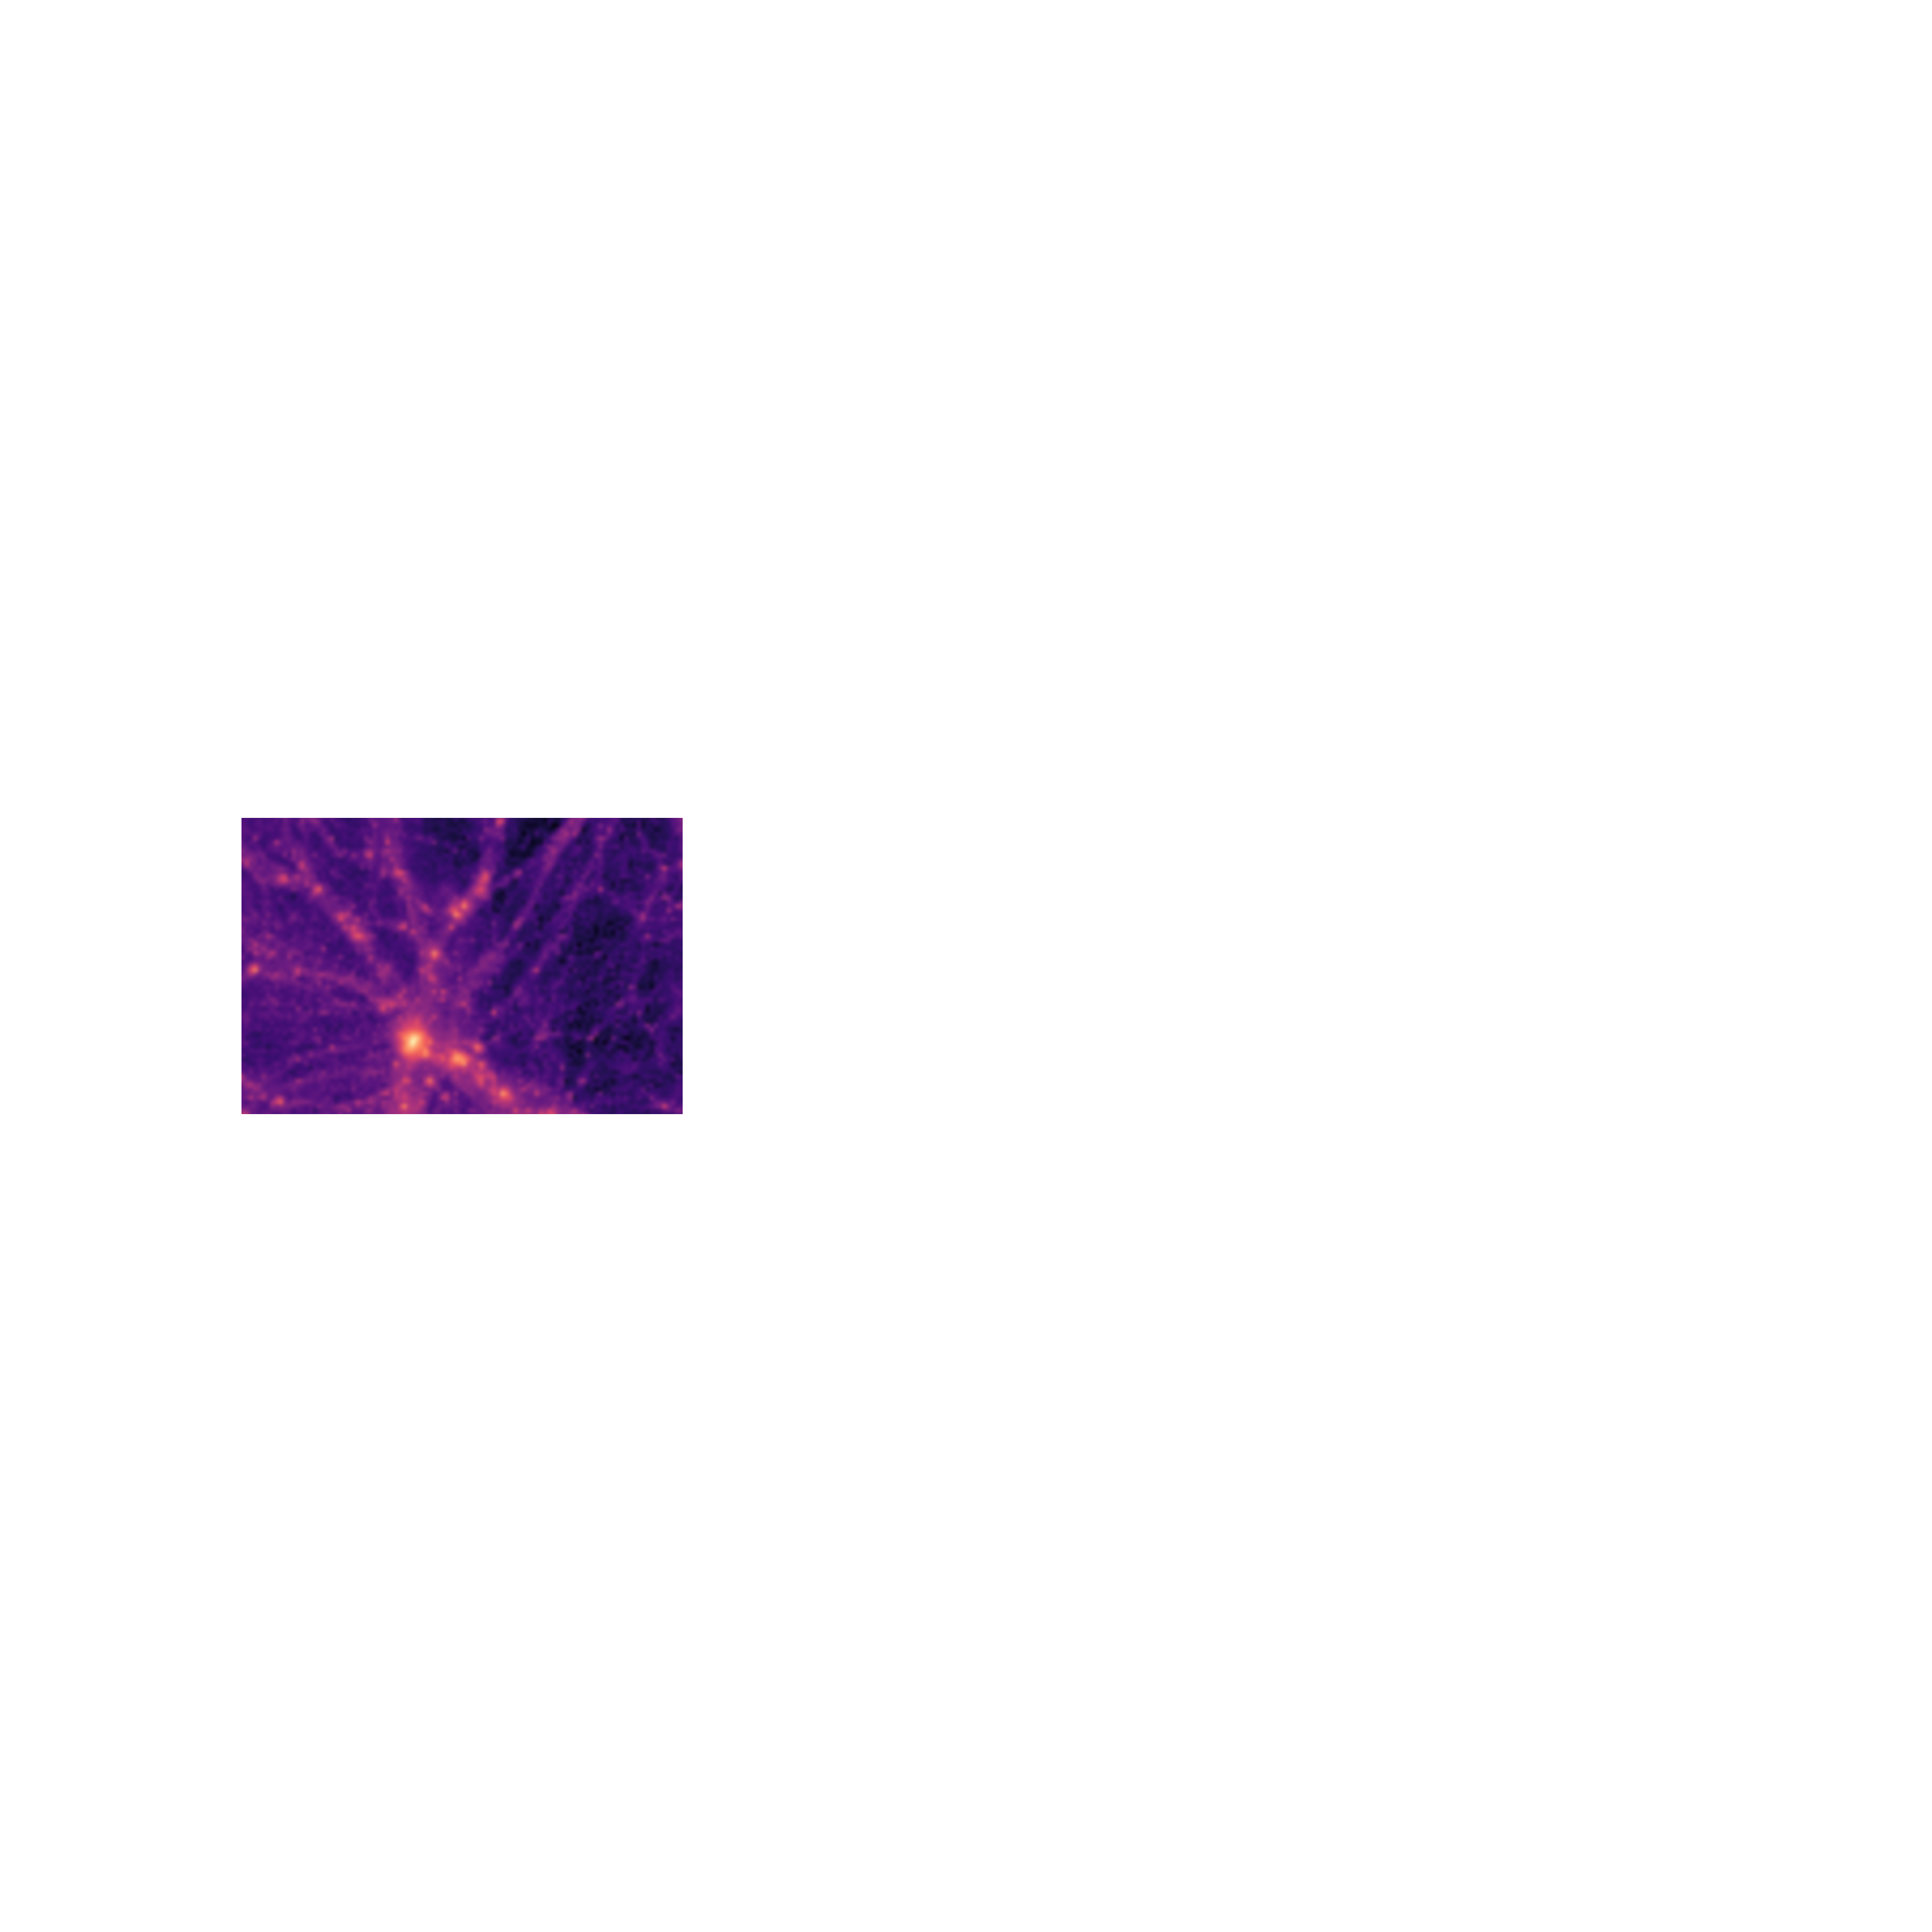

(0.49290584958759798, 36905813.473390907, 0.0, 36905813.473390907)

In [8]:
fig = plt.figure(figsize=(45, 45))
ax = fig.add_subplot(131)
ax.imshow(H, interpolation='quadric', origin='low',cmap='magma',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
          norm=LogNorm(vmin=H[(H>0)].min(), vmax=H.max()))
plt.axis('off')
#ax.scatter(halos_x_f,halos_y_f,s=100*halos_r_f/halos_r_f.max(),
#           facecolors='none')
#ax.scatter(halos_x,halos_y,marker='o', color='white')